In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18


In [2]:
#Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
#Initiate transform to turn images to the correct size for CNN, transform to tensor and standardize each colro channel
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
#Load data and split into train and validation. Check how many classes we have 

full_data = datasets.ImageFolder(
    root = '/Users/elenalapteva/Desktop/scripts for work/deep learning /archive/dataset_train/dataset_train',
    transform=transform
)

train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size

train_data, val_data = torch.utils.data.random_split(
    full_data, [train_size, val_size]
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=32, shuffle=False
)

num_classes = len(full_data.classes)
print("Number of classes:", num_classes)


Number of classes: 19


In [5]:
#Initiate the resnet model
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


/opt/anaconda3/envs/mlenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mlenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
#Initiate our loss function 
criterion = nn.CrossEntropyLoss()


In [7]:
#Freeze backbone and unfreeze the classifier layer to train on categories we have
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


In [8]:
#Initiate optimizer and set the learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [9]:
#Training the classifier for 5 epochs
epochs_phase1 = 5

for epoch in range(epochs_phase1):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    print(
        f"[PHASE 1] Epoch {epoch+1}/{epochs_phase1} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}"
    )


[PHASE 1] Epoch 1/5 | Train Loss: 2.7115 | Train Acc: 0.1643
[PHASE 1] Epoch 2/5 | Train Loss: 2.4370 | Train Acc: 0.2546
[PHASE 1] Epoch 3/5 | Train Loss: 2.3506 | Train Acc: 0.2839
[PHASE 1] Epoch 4/5 | Train Loss: 2.3097 | Train Acc: 0.2938
[PHASE 1] Epoch 5/5 | Train Loss: 2.2716 | Train Acc: 0.3035


In [10]:
#Setup for phase 2 of training
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in model.fc.parameters():
    param.requires_grad = True

# Unfreeze last ResNet block
for param in model.layer4.parameters():
    param.requires_grad = True


In [11]:
#Initiliaze optimizer, set separate learning rates for classifier and 4th layer. 
#Including weight decay to regularize the classifier head and reduce overfitting on a small dataset
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 3e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)


In [12]:
#Phase 2 of training andf validation 
epochs_phase2 = 10
best_val_acc = 0.0
best_epoch = -1
patience = 2
counter = 0

for epoch in range(epochs_phase2):

    
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(
        f"[PHASE 2] Epoch {epoch+1}/{epochs_phase2} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Checkpoint setup + early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        counter = 0

        checkpoint = {
            "model_state": model.state_dict(),
            "num_classes": num_classes,
            "class_names": full_data.classes,
            "epoch": best_epoch,
            "val_acc": best_val_acc
        }

        torch.save(checkpoint, "best_model.pt")

    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print(f"Best model was from epoch {best_epoch} with acc {best_val_acc:.4f}")


[PHASE 2] Epoch 1/10 | Train Acc: 0.3450 | Val Acc: 0.3004
[PHASE 2] Epoch 2/10 | Train Acc: 0.4756 | Val Acc: 0.3182
[PHASE 2] Epoch 3/10 | Train Acc: 0.6005 | Val Acc: 0.3179
[PHASE 2] Epoch 4/10 | Train Acc: 0.7380 | Val Acc: 0.3169
Early stopping triggered at epoch 4
Best model was from epoch 2 with acc 0.3182


Thoughts on the accuracy score:
- The model quickly fits the training data but plateaus on validation accuracy, illustrating classic overfitting.
- This behavior is expected because the images are not semantically aligned with the labels.
- The result confirms that the pipeline is correct and highlights a core ML principle:  
  *Models can memorize arbitrary mappings, but cannot generalize without meaningful structure in the data.*


In [13]:
checkpoint = torch.load("best_model.pt", map_location=device)

num_classes = checkpoint["num_classes"]
class_names = checkpoint["class_names"]

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(checkpoint["model_state"])
model = model.to(device)
model.eval()


/opt/anaconda3/envs/mlenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
test_data = datasets.ImageFolder(
    root = '/Users/elenalapteva/Desktop/scripts for work/deep learning /archive/dataset_test/dataset_test',
    transform=transform
)


In [15]:
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=False
)

In [16]:
model.eval()
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = test_correct / len(test_loader.dataset)
print("Final Test Accuracy:", test_acc)


Final Test Accuracy: 0.32475194422097076


In [17]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


**Building a multimidal ML model(optional)**

This part below is optional, I just decide to experiment with some datasets that I had to see what would happen if I combined them, how the model would perform

In [18]:
checkpoint = torch.load("best_model.pt", map_location="cpu")
num_classes = checkpoint["num_classes"]

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(checkpoint["model_state"])
model.fc = nn.Identity()

for param in model.parameters():
    param.requires_grad = False
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
#Creating csv file with images embeddings
import csv
import os


model.eval()

csv_path = "image_embeddings.csv"

# Create header once
header = ["label"] + [f"emb_{i}" for i in range(512)]

# Write header if file does not exist
file_exists = os.path.isfile(csv_path)

with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)

    if not file_exists:
        writer.writerow(header)

    for image, label in full_data:


        with torch.no_grad():
            embedding = model(image.unsqueeze(0))  # (1, 512)

        embedding = embedding.squeeze(0).cpu().numpy()

        row = [label] + embedding.tolist()
        writer.writerow(row)



In [20]:
#since the images are not tied to any real house,I am randomly assigning 1–3 image embeddings to each house in the dataset
#and averaging them
import pandas as pd
import numpy as np
import random

# Load data
housing_df = pd.read_csv("/Users/elenalapteva/Desktop/scripts for work/house-prices-advanced-linear regression-techniques/train.csv")
img_df = pd.read_csv("image_embeddings.csv")

embedding_cols = [c for c in img_df.columns if c.startswith("emb_")]

rows = []

# Shuffle images once for randomness
img_indices = list(range(len(img_df)))

for house_id in housing_df["Id"]:
    # Pick 1–3 images for this house
    k = random.randint(1, 3)
    chosen = random.sample(img_indices, k)

    # Get their embeddings
    selected = img_df.iloc[chosen][embedding_cols].values

    # Average them
    mean_embedding = selected.mean(axis=0)

    row = {"Id": house_id}
    row.update({col: val for col, val in zip(embedding_cols, mean_embedding)})
    rows.append(row)

visual_df = pd.DataFrame(rows)

# Save
visual_df.to_csv("house_visual_features.csv", index=False)


In [21]:
#Merge the data and separate the labels
merged = housing_df.merge(visual_df, on="Id")

y = merged.pop("SalePrice")
X = merged


In [22]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 592 entries, Id to emb_511
dtypes: float64(515), int64(34), object(43)
memory usage: 6.6+ MB


In [23]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=5)

In [24]:
# Convert all object columns to category
for col in train_X.select_dtypes(include="object").columns:
    train_X[col] = train_X[col].astype("category")
    test_X[col]  = test_X[col].astype("category")

In [25]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 1358 to 867
Columns: 592 entries, Id to emb_511
dtypes: category(43), float64(515), int64(34)
memory usage: 5.0 MB


In [26]:
#Initiate the model
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    enable_categorical=True,
    tree_method = "hist",
    eval_metric = "rmse",
    random_state=5)


In [27]:
model.fit(train_X, train_y)      # training
y_pred = model.predict(test_X)   # inference

In [28]:
model.score (train_X, train_y)

0.9999999055591035

In [29]:
model.score (test_X, test_y)

0.8548980552885459

In [30]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error (test_y, y_pred)

In [31]:
print (mse)
rmse = np.sqrt (mse)
print (rmse)

941712578.6385437
30687.33580222538


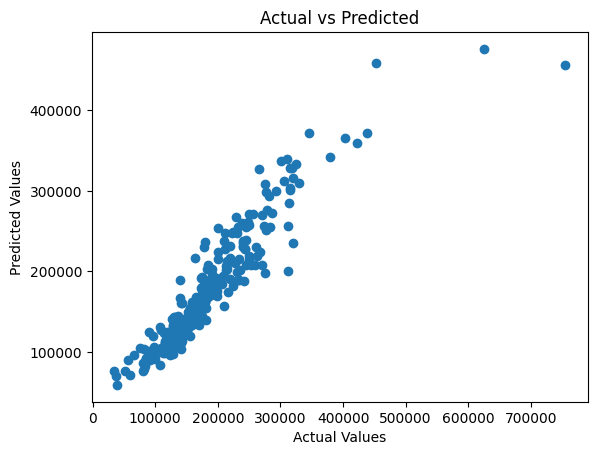

In [32]:
import matplotlib.pyplot as plt

plt.scatter (test_y, y_pred)
plt.xlabel ('Actual Values')
plt.ylabel ('Predicted Values')
plt.title ('Actual vs Predicted')
plt.show()

**Comparing our multimodal performance to model performance without image embeddings**

In [33]:
data_without_images = data = pd.read_csv("/Users/elenalapteva/Desktop/scripts for work/house-prices-advanced-linear regression-techniques/train.csv")

In [34]:
y2 = data_without_images.pop("SalePrice")
X2 = data_without_images


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=5)

In [36]:
# Convert all object columns to category
for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col]  = X_test[col].astype("category")

In [37]:
model.fit(X_train, y_train)      # training
pred_y = model.predict(X_test) 

In [38]:
model.score (X_train, y_train)

0.9997086282704712

In [39]:
model.score (X_test, y_test)

0.8703098365693619

In [40]:
mse = mean_squared_error (y_test, pred_y)
print (mse)
rmse = np.sqrt (mse)
print (rmse)

841690016.430769
29011.894395760664


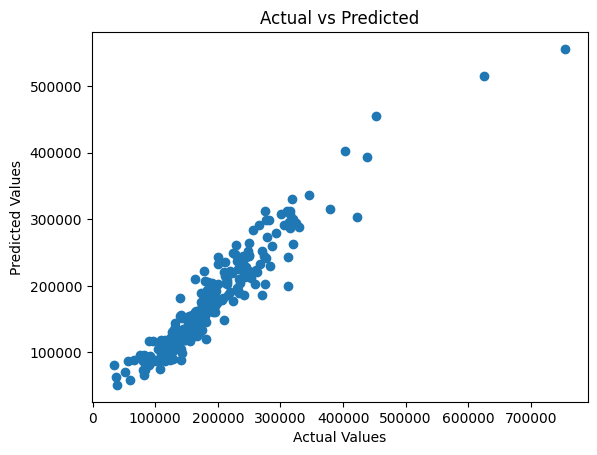

In [41]:
import matplotlib.pyplot as plt
 
plt.scatter (y_test,pred_y)
plt.xlabel ('Actual Values')
plt.ylabel ('Predicted Values')
plt.title ('Actual vs Predicted')
plt.show()

**Conclusion**

This section was exploratory and served as an experimental extension of the core pipeline. I intentionally combined unrelated datasets to simulate a multimodal setting and observe how the model behaves when visual embeddings are fused with structured tabular data. While the image–house associations are synthetic, this experiment demonstrates the mechanics of building a multimodal dataset and provides insight into how such a system would perform in practice. The goal here was not to achieve optimal predictive accuracy, but to validate the end-to-end workflow and establish a foundation for future experiments with semantically aligned data!